# Imports

In [1]:
import time
import requests
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Dropout, Input, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import SGD

# HTTPS Requests, to send status via TelegramBot

In [2]:
def telegram_bot_sendtext(bot_message):
    
    bot_token = 'ENTER YOUR BOT TOKEN'
    bot_chatID = 'ENTER CHAT ID'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()

telegram_bot_sendtext('Start Script')

{'ok': True,
 'result': {'message_id': 7300,
  'from': {'id': 862297446,
   'is_bot': True,
   'first_name': 'Daniel_bot',
   'username': 'KingArschFickerBot'},
  'chat': {'id': 660201452,
   'first_name': 'Daniel',
   'username': 'ps3ud0nym',
   'type': 'private'},
  'date': 1580841224,
  'text': 'Start Script'}}

# Load Data


1. Add the *Dogs vs. Cats Redux: Kernels Edition* on the top right __+ Add Data__
   
   Now we have the folling folder structure:  
   
   ├── Dogs vs. Cats Redux: Kernels Edition  
   │   ├── test.zip  
   │   ├── train.zip  
   │   └── sample_submission.csv  
   
   
2. Next we need to extract train and test data. We will use __ZipFile__ for that. Since the input directory is a __read only__ directory, we have to extract the zip files into the output directory.

In [3]:
with ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip') as zipobj:
    zipobj.extractall('../working')
with ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip') as zipobj:
    zipobj.extractall('../working')

In [ ]:
train_data = os.listdir('../working/train')
test_data = os.listdir('../working/test')

os.mkdir('../working/train/cats')
os.mkdir('../working/train/dogs')
os.mkdir('../working/test/cats')
os.mkdir('../working/test/dogs')
os.mkdir('../working/models')

for i in train_data:
    print(i)
    if (i != 'cats') and (i != 'dogs'):
        if 'cat' in i:
            os.replace("../working/train/"+i, "../working/train/cats/"+i)
        elif 'dog' in i:
            os.replace("../working/train/"+i, "../working/train/dogs/"+i)

 3. After extraction and sorting we have the following folder structure:
 
 ├── working   
 │   ├── train   
 │   │    ├── cats  
 │   │    └── dogs  
 │   ├── test    
 │   └── sample_submission.csv    

# Data Generator

In [5]:
bs=32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../working/train',
        target_size=(128, 128),
        batch_size=bs,
        class_mode='binary',
        subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
        '../working/train',
        target_size=(128, 128),
        batch_size=bs,
        class_mode='binary',
        subset='validation') # set as validation data

test_generator = test_datagen.flow_from_directory(
        '../working',
        target_size=(128, 128),
        batch_size=1,
        classes=['test'])

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


# Define and Train model

In [6]:
lr=None
modelname=''
model_destination = '../working/models/'
optimizer = ''
# define cnn model
def vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    optimizer = opt.__dict__['_name']
    lr = opt.__dict__['_hyper']['learning_rate']
    global modelname
    modelname ='VGG'
    return model

classification_model = vgg()
print('Done!')

Done!


In [7]:
training = classification_model.fit_generator(train_generator, epochs=100, validation_data=validation_generator)#, callbacks=)
history = training.history
telegram_bot_sendtext('Training finished!')

Train for 625 steps, validate for 157 steps
Epoch 1/100
625/625 [==============================] - 142s 228ms/step - loss: 0.6817 - accuracy: 0.5649 - val_loss: 0.6697 - val_accuracy: 0.5806
Epoch 2/100
625/625 [==============================] - 139s 223ms/step - loss: 0.6536 - accuracy: 0.6096 - val_loss: 0.6813 - val_accuracy: 0.5706
Epoch 3/100
625/625 [==============================] - 140s 224ms/step - loss: 0.6422 - accuracy: 0.6225 - val_loss: 0.6242 - val_accuracy: 0.6566
Epoch 4/100
625/625 [==============================] - 139s 222ms/step - loss: 0.6248 - accuracy: 0.6442 - val_loss: 0.6115 - val_accuracy: 0.6596
Epoch 5/100
625/625 [==============================] - 139s 222ms/step - loss: 0.6088 - accuracy: 0.6670 - val_loss: 0.6070 - val_accuracy: 0.6682
Epoch 6/100
625/625 [==============================] - 140s 224ms/step - loss: 0.5933 - accuracy: 0.6805 - val_loss: 0.5888 - val_accuracy: 0.6850
Epoch 7/100
625/625 [==============================] - 139s 223ms/step - l

# Save Model and training history

In [8]:
classification_model.save(f"{model_destination}{modelname}_bs_{bs}_{optimizer}_{lr}.h5")

hist_df = pd.DataFrame(history)
hist_df.to_csv(f'history{modelname}_bs_{bs}_{optimizer}_{lr}.csv')
telegram_bot_sendtext(str(history))
telegram_bot_sendtext('Model saved!')

{'ok': True,
 'result': {'message_id': 7302,
  'from': {'id': 862297446,
   'is_bot': True,
   'first_name': 'Daniel_bot',
   'username': 'KingArschFickerBot'},
  'chat': {'id': 660201452,
   'first_name': 'Daniel',
   'username': 'ps3ud0nym',
   'type': 'private'},
  'date': 1580855103,
  'text': 'Model saved!'}}

# Evaluate Training

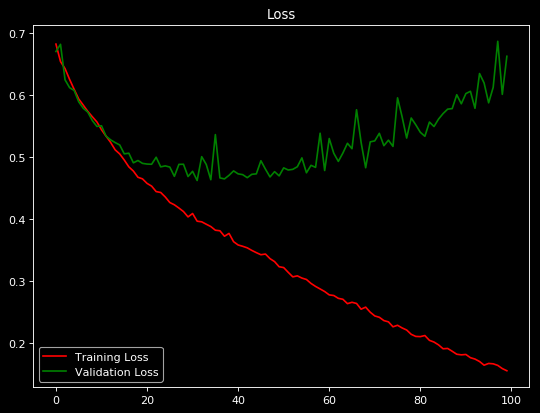

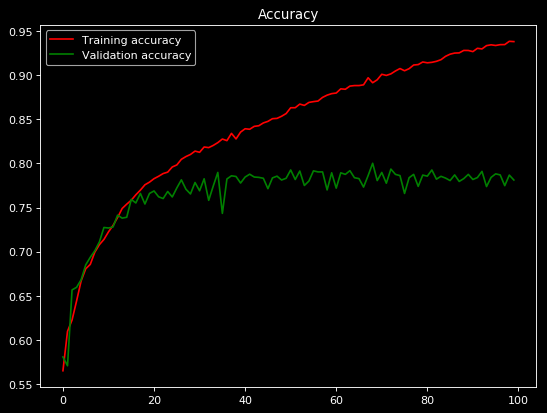

In [9]:
plt.style.use('dark_background')
#history['loss'] = [1,2,3,4,5]
#history['accuracy'] = [5,4,3,2,1]
#history['val_loss'] = [2,4,6,8,10]
#history['val_accuracy'] = [10,8,6,4,2]
#history = training.history

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.title('Loss')
plt.plot(history['loss'], color='red')
plt.plot(history['val_loss'], color='green')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.title('Accuracy')
plt.plot(history['accuracy'], color='red')
plt.plot(history['val_accuracy'], color='green')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np

validation_generator.shuffle = False
validation_generator.index_array = None

y_pred = classification_model.predict_generator(validation_generator)
y_label = validation_generator.classes

# Save y_pred and y_label into Dataframe
#pd.DataFrame({'y_pred':y_pred, 'y_label':y_label})

# Confusion MATRIX cat=0 dog=1
# roundpredictions
y_pred_bin = np.where(y_pred > 0.5, 1, 0)

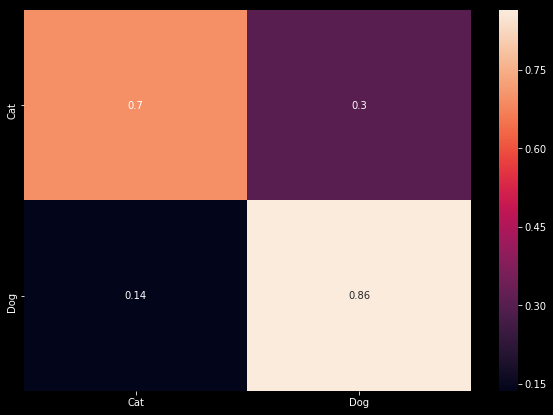

In [11]:

[[tn, fp], [fn, tp]] = confusion_matrix(y_label, y_pred_bin, labels=[0, 1])# normalize='all')
array = [[tn/(tn+fp),fp/(tn+fp)], 
        [fn/(tp+fn),tp/(tp+fn)]]
df_cm = pd.DataFrame(array, index = ["Cat","Dog"],
                  columns = ["Cat","Dog"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Prepare Submission

In [12]:
predicted = classification_model.predict_generator(test_generator)
sample_submission = pd.read_csv("../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv")
sample_submission.label = predicted
sample_submission.to_csv('next_submission.csv')

# Delete Dataset from working directory

We delete it in order to keep our output section clean

In [13]:
import shutil

shutil.rmtree('../working/train')
shutil.rmtree('../working/test')